<a href="https://colab.research.google.com/github/jiin124/Toy_project/blob/main/%EC%A3%BC%EC%8B%9D_%EC%8B%9C%EA%B3%84%EC%97%B4%EC%98%88%EC%B8%A1/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EC%8B%9D_%EC%8B%9C%EA%B3%84%EC%97%B4%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 삼성전자 주식 시계열 예측

https://finance.yahoo.com/quote/005930.KS?p=005930.KS&.tsrc=fin-srch
여기서 5년동안의 주식 데이터를 다운로드하여 LSTM을 이용해 예측함. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,Activation
import datetime

In [2]:
df=pd.read_csv('/content/005930.KS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-02,45060,45960,45000,45960,39812.25781,12488750
1,2017-06-05,46040,46360,45720,45940,39794.92969,7599400
2,2017-06-07,46500,46500,45240,45300,39240.53516,13729400
3,2017-06-08,45000,45580,45000,45160,39119.26563,13978750
4,2017-06-09,45680,46440,45600,46100,39933.52734,11732850


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1225 non-null   object 
 1   Open       1225 non-null   int64  
 2   High       1225 non-null   int64  
 3   Low        1225 non-null   int64  
 4   Close      1225 non-null   int64  
 5   Adj Close  1225 non-null   float64
 6   Volume     1225 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 67.1+ KB


# mid price

In [4]:
high_prices=df['High'].values
low_prices=df['Low'].values
mid_prices=(high_prices+low_prices)/2

In [5]:
seq_len=50
sequence_length=seq_len+1

result=[]
for index in range(len(mid_prices)-sequence_length):
  result.append(mid_prices[index:index+sequence_length])

In [7]:
result[:2]

[array([45480., 46040., 45870., 45290., 46020., 45370., 45380., 45650.,
        45550., 45700., 46060., 47680., 47800., 47900., 47600., 47940.,
        48150., 47780., 48130., 47360., 47450., 47150., 47230., 47910.,
        47870., 48610., 48640., 49420., 50490., 50750., 50770., 50620.,
        50410., 50940., 50840., 50810., 50350., 49660., 50100., 48590.,
        47580., 48190., 48970., 48060., 47840., 47760., 47870., 46820.,
        45890., 44760., 45060.]),
 array([46040., 45870., 45290., 46020., 45370., 45380., 45650., 45550.,
        45700., 46060., 47680., 47800., 47900., 47600., 47940., 48150.,
        47780., 48130., 47360., 47450., 47150., 47230., 47910., 47870.,
        48610., 48640., 49420., 50490., 50750., 50770., 50620., 50410.,
        50940., 50840., 50810., 50350., 49660., 50100., 48590., 47580.,
        48190., 48970., 48060., 47840., 47760., 47870., 46820., 45890.,
        44760., 45060., 46190.])]

최근 50일간의 데이터를 보고 에측
윈도우의 개념 설명 필수

# normalized data

In [9]:
def normalize_windows(data):
  normalized_data=[]
  for window in data:
    normalized_window=[((float(p)/float(window[0]))-1) for p in window]
    normalized_data.append(normalized_window)
  return np.array(normalized_data)

result=normalize_windows(result)

In [12]:
result[:1174,:].shape

(1174, 51)

## Split train and test data

In [13]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

train

array([[ 0.        , -0.02256318, -0.05866426, ...,  0.06407942,
         0.05595668,  0.01895307],
       [ 0.        ,  0.00062112,  0.00559006, ...,  0.12546584,
         0.11614907,  0.11180124],
       [ 0.        ,  0.01753325,  0.00846433, ..., -0.01088271,
        -0.00060459, -0.01027811],
       ...,
       [ 0.        , -0.00223339, -0.01954216, ..., -0.01898381,
        -0.01563372, -0.00670017],
       [ 0.        , -0.00150754,  0.0040201 , ..., -0.07085427,
        -0.06532663, -0.06080402],
       [ 0.        , -0.02247807, -0.01151316, ...,  0.0252193 ,
         0.02960526,  0.03618421]])

In [14]:
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

In [15]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [17]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    )

Epoch 1/20
106/106 [==============================] - 8s 43ms/step - loss: 0.0024 - val_loss: 4.1247e-04
Epoch 2/20
106/106 [==============================] - 4s 35ms/step - loss: 0.0010 - val_loss: 4.2060e-04
Epoch 3/20
106/106 [==============================] - 4s 35ms/step - loss: 7.5322e-04 - val_loss: 4.4944e-04
Epoch 4/20
106/106 [==============================] - 5s 51ms/step - loss: 5.3441e-04 - val_loss: 3.6935e-04
Epoch 5/20
106/106 [==============================] - 4s 35ms/step - loss: 5.0943e-04 - val_loss: 1.7304e-04
Epoch 6/20
106/106 [==============================] - 4s 35ms/step - loss: 3.9662e-04 - val_loss: 2.0342e-04
Epoch 7/20
106/106 [==============================] - 4s 35ms/step - loss: 3.6690e-04 - val_loss: 1.3659e-04
Epoch 8/20
106/106 [==============================] - 4s 36ms/step - loss: 3.2159e-04 - val_loss: 1.2826e-04
Epoch 9/20
106/106 [==============================] - 4s 35ms/step - loss: 3.1004e-04 - val_loss: 3.6980e-04
Epoch 10/20
106/106 [======

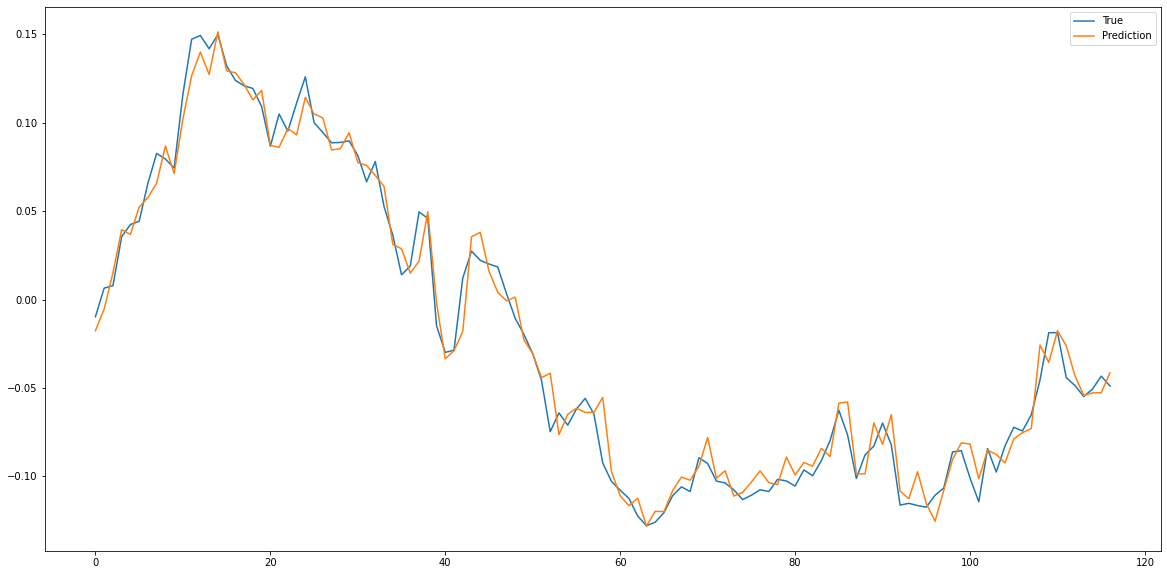

In [18]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()